In [1]:
import numpy as np
import pandas as pd
from os import listdir
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
%matplotlib inline


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.decomposition import KernelPCA, PCA
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import RepeatedKFold, cross_validate, StratifiedKFold, StratifiedShuffleSplit
from sklearn.metrics import accuracy_score
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, utils
import operator
import time
import os
from random import shuffle

import random
from tqdm import trange
import PIL.Image as Image
from IPython import display

import warnings
warnings.simplefilter(action='ignore')

RANDOM_STATE = 42
%matplotlib inline

In [31]:
def make_hist_pupil(data,bins, min_diff):
    data = data.dropna()
    maximum = data['Pupil Area'].max()
    print(maximum)
    data['Pupil Area'] = data['Pupil Area'] / maximum
    
    data_video_DA = data.loc[data['Trial Name'] == 'DadsArmy']
    data_video_DA.set_index(np.arange(data_video_DA.shape[0]))
    
    data_video_HB = data.loc[data['Trial Name'] == 'HistoryBoys']
    data_video_HB.set_index(np.arange(data_video_HB.shape[0]))
    
    data_video_SC = data.loc[data['Trial Name'] == 'SkiCross']
    data_video_SC.set_index(np.arange(data_video_SC.shape[0]))
    
    pupil_hist_DA = np.zeros(bins)
    pupil_hist_HB = np.zeros(bins)
    pupil_hist_SC = np.zeros(bins)
    
    for i in range(data_video_DA.shape[0]):
        if data_video_DA['Pupil Area'].iloc[i] > min_diff:
            pupil_hist_DA[int((data_video_DA['Pupil Area'].iloc[i] - min_diff)*(bins - 1)/(1 - min_diff))] += 1
        
    for i in range(data_video_HB.shape[0]):
        if data_video_HB['Pupil Area'].iloc[i] > min_diff:
            pupil_hist_HB[int((data_video_HB['Pupil Area'].iloc[i] - min_diff)*(bins - 1)/(1 - min_diff))] += 1        
    
    for i in range(data_video_SC.shape[0]):
        if data_video_SC['Pupil Area'].iloc[i] > min_diff:
            pupil_hist_SC[int((data_video_SC['Pupil Area'].iloc[i] - min_diff)*(bins - 1)/(1 - min_diff))] += 1    
    
    return pupil_hist_DA/data_video_DA.shape[0],pupil_hist_HB/data_video_HB.shape[0],pupil_hist_SC/data_video_SC.shape[0]


In [434]:
16/9

1.7777777777777777

In [544]:
def make_density_map(data, min_saccade,n_rows,m_columns):
    data = data.dropna()
    size = 64
    dn = 2*size//n_rows + 1
    dm = 2*size//m_columns + 1
    pixels_num_x = 1600//20.3*2
    pixels_num_y = 1200//14.9*2
    bound_y_max =  pixels_num_y*5
    bound_y_min = - pixels_num_y*5
    bound_x_max =  pixels_num_x*6
    bound_x_min = - pixels_num_x*6    
    mult_x = 12/(bound_x_max - bound_x_min)
    mult_y = 10/(bound_y_max - bound_y_min)
    data_video_DA = data.loc[data['Trial Name'] == 'DadsArmy']
    data_video_DA.set_index(np.arange(data_video_DA.shape[0]))
    
    data_video_HB = data.loc[data['Trial Name'] == 'HistoryBoys']
    data_video_HB.set_index(np.arange(data_video_HB.shape[0]))
    
    data_video_SC = data.loc[data['Trial Name'] == 'SkiCross']
    data_video_SC.set_index(np.arange(data_video_SC.shape[0]))

    den_map_DA =np.zeros((n_rows,m_columns))
    den_map_HB =np.zeros((n_rows,m_columns))
    den_map_SC =np.zeros((n_rows,m_columns))

    for i in range(data_video_DA.shape[0]):
        
        if bound_x_min < data_video_DA['delta X'].iloc[i] < bound_x_max:
            if bound_y_min < data_video_DA['delta Y'].iloc[i] < bound_y_max:
                den_map_DA[4 + int(data_video_DA['delta Y'].iloc[i] * mult_y) ,5+ int(data_video_DA['delta X'].iloc[i]*mult_x)] += 1
    
    pixels_num_x = 1600//17.3*2
    pixels_num_y = 900//10.6*2
    bound_y_max =pixels_num_y*5
    bound_y_min = - pixels_num_y*5
    bound_x_max =  pixels_num_x*6
    bound_x_min = - pixels_num_x*6 
    mult_x = 12/(bound_x_max - bound_x_min)
    mult_y = 10/(bound_y_max - bound_y_min)
    for i in range(data_video_HB.shape[0]):
        if bound_x_min < data_video_HB['delta X'].iloc[i] < bound_x_max:
            if bound_y_min < data_video_HB['delta Y'].iloc[i] < bound_y_max:
                den_map_HB[4 + int(data_video_HB['delta Y'].iloc[i]* mult_y) , 5 + int(data_video_HB['delta X'].iloc[i]*mult_x)] += 1

    for i in range(data_video_SC.shape[0]):
        if bound_x_min < data_video_SC['delta X'].iloc[i] < bound_x_max:
            if bound_y_min < data_video_SC['delta Y'].iloc[i] < bound_y_max:
                den_map_SC[4 + int(data_video_SC['delta Y'].iloc[i] * mult_y) , 5 + int(data_video_SC['delta X'].iloc[i]*mult_x)] += 1
                
                
    return den_map_DA/den_map_DA.sum(), den_map_HB/den_map_HB.sum(),den_map_SC/den_map_SC.sum()



In [445]:
# def make_density_map(data, min_saccade,n_rows,m_columns):
#     data = data.dropna()
#     size = 64
#     dn = 2*size//n_rows + 1
#     dm = 2*size//m_columns + 1
#     data['delta X'] = (size - 1) * data['delta X'] / max(data['delta X'].max(), - data['delta X'].min())
#     data['delta Y'] = (size - 1) * data['delta Y'] / max(data['delta Y'].max(), - data['delta Y'].min())


    
#     data_video_DA = data.loc[data['Trial Name'] == 'DadsArmy']
#     data_video_DA.set_index(np.arange(data_video_DA.shape[0]))
    
#     data_video_HB = data.loc[data['Trial Name'] == 'HistoryBoys']
#     data_video_HB.set_index(np.arange(data_video_HB.shape[0]))
    
#     data_video_SC = data.loc[data['Trial Name'] == 'SkiCross']
#     data_video_SC.set_index(np.arange(data_video_SC.shape[0]))

#     den_map_DA =np.zeros((n_rows,m_columns))
#     den_map_HB =np.zeros((n_rows,m_columns))
#     den_map_SC =np.zeros((n_rows,m_columns))

#     for i in range(data_video_DA.shape[0]):
#         if np.sqrt((data_video_DA['delta X'].iloc[i])**2 + (data_video_DA['delta Y'].iloc[i])**2) > min_saccade:
#             den_map_DA[(size + int(data_video_DA['delta X'].iloc[i]) )// dn, (size + int(data_video_DA['delta Y'].iloc[i]))//dm] += 1
    
    
#     for i in range(data_video_HB.shape[0]):
#         if np.sqrt((data_video_HB['delta X'].iloc[i])**2 + (data_video_HB['delta Y'].iloc[i])**2) > min_saccade:
#             den_map_HB[(size + int(data_video_HB['delta X'].iloc[i]) )// dn, (size + int(data_video_HB['delta Y'].iloc[i]))//dm] += 1

#     for i in range(data_video_SC.shape[0]):
#         if np.sqrt((data_video_SC['delta X'].iloc[i])**2 + (data_video_SC['delta Y'].iloc[i])**2) > min_saccade:
#             den_map_SC[(size + int(data_video_SC['delta X'].iloc[i]) )// dn, (size + int(data_video_SC['delta Y'].iloc[i]))//dm] += 1
                
                
#     return den_map_DA/data_video_DA.shape[0], den_map_HB/data_video_HB.shape[0],den_map_SC/data_video_SC.shape[0]


In [545]:
def make_picture(data, min_saccade,size): # drop one video 
    data = data.dropna()


    data['delta X'] = (size - 1) * data['delta X'] / max(data['delta X'].max(), - data['delta X'].min())
    data['delta Y'] = (size - 1) * data['delta Y'] / max(data['delta Y'].max(), - data['delta Y'].min())    
    
    data_video_DA = data.loc[data['Trial Name'] == 'DadsArmy']
    data_video_DA.set_index(np.arange(data_video_DA.shape[0]))
    
    data_video_HB = data.loc[data['Trial Name'] == 'HistoryBoys']
    data_video_HB.set_index(np.arange(data_video_HB.shape[0]))
    
    data_video_SC = data.loc[data['Trial Name'] == 'SkiCross']
    data_video_SC.set_index(np.arange(data_video_SC.shape[0]))

    picture_DA = 255* np.ones((2*size,2*size))
    picture_HB = 255* np.ones((2*size,2*size))
    picture_SC = 255* np.ones((2*size,2*size))
    
    for i in range(data_video_DA.shape[0]):
        if np.sqrt((data_video_DA['delta X'].iloc[i])**2 + (data_video_DA['delta Y'].iloc[i])**2) > min_saccade:
            picture_DA[size + int(data_video_DA['delta X'].iloc[i]), size + int(data_video_DA['delta Y'].iloc[i]) ] = 0 


    for i in range(data_video_HB.shape[0]):
        if np.sqrt((data_video_HB['delta X'].iloc[i])**2 + (data_video_HB['delta Y'].iloc[i])**2) > min_saccade:
            picture_HB[size + int(data_video_HB['delta X'].iloc[i]), size + int(data_video_HB['delta Y'].iloc[i]) ] = 0 


    for i in range(data_video_SC.shape[0]):
        if np.sqrt((data_video_SC['delta X'].iloc[i])**2 + (data_video_SC['delta Y'].iloc[i])**2) > min_saccade:
            picture_SC[size + int(data_video_SC['delta X'].iloc[i]), size + int(data_video_SC['delta Y'].iloc[i]) ] = 0 
    
    return picture_DA/data_video_DA.shape[0],picture_HB/data_video_HB.shape[0],picture_SC/data_video_SC.shape[0]



In [447]:
def fix_sac_sep_clean(tempdata):
    tempdata = tempdata.replace(".", np.nan)
    tempdata['Duration'] = tempdata['Duration'] - 1
    tempdata["Start X"] = pd.to_numeric(tempdata["Start X"])
    tempdata["Start Y"] = pd.to_numeric(tempdata["Start Y"])
    tempdata["End X"] = pd.to_numeric(tempdata["End X"])
    tempdata["End Y"] = pd.to_numeric(tempdata["End Y"])

    tempdata_suc = pd.DataFrame(tempdata.dropna().loc[tempdata['Tracking type'] == 'Saccade' ], columns=tempdata.columns)
    tempdata_suc = tempdata_suc.drop(tempdata_suc.loc[tempdata_suc['Amplitude'] > 1000].index) # drop bad values
    tempdata_suc.index = np.arange(tempdata_suc.shape[0])
    tempdata_suc = tempdata_suc.drop(tempdata_suc.loc[tempdata_suc['Start X'] > 1600].index)
    tempdata_suc = tempdata_suc.drop(tempdata_suc.loc[tempdata_suc['End X'] > 1600].index)
    tempdata_suc = tempdata_suc.drop(tempdata_suc.loc[tempdata_suc['Start Y'] > 1200].index)
    tempdata_suc = tempdata_suc.drop(tempdata_suc.loc[tempdata_suc['End Y'] > 1200].index)
    tempdata_suc = tempdata_suc.drop(tempdata_suc.loc[tempdata_suc['Start X'] < 1 ].index)
    tempdata_suc = tempdata_suc.drop(tempdata_suc.loc[tempdata_suc['End X'] < 1].index)
    tempdata_suc = tempdata_suc.drop(tempdata_suc.loc[tempdata_suc['Start Y'] < 1].index)
    tempdata_suc = tempdata_suc.drop(tempdata_suc.loc[tempdata_suc['End Y'] < 1].index)


    tempdata_fix = pd.DataFrame(tempdata.loc[tempdata['Tracking type'] == 'Fixation' ].values[:,:9], columns=['Fixation', 'Trial Name', 'Eye', 'Start Time', 'End Time', 'Duration',
       'X', 'Y', 'Pupil Area'])
    tempdata_fix['Start Time'] = pd.to_numeric(tempdata_fix['Start Time'])
    tempdata_fix['End Time'] = pd.to_numeric(tempdata_fix['Start Time'])
    tempdata_fix['Duration'] = pd.to_numeric(tempdata_fix['Duration'])
    tempdata_fix['X'] = pd.to_numeric(tempdata_fix['X'])
    tempdata_fix['Y'] = pd.to_numeric(tempdata_fix['Y'])
    tempdata_fix['Pupil Area'] = pd.to_numeric(tempdata_fix['Pupil Area'])
    tempdata_fix.index = np.arange(tempdata_fix.shape[0])
    tempdata_fix = tempdata_fix.drop(tempdata_fix.loc[tempdata_fix['X'] > 1600].index)
    tempdata_fix = tempdata_fix.drop(tempdata_fix.loc[tempdata_fix['Y'] > 1200].index)
    tempdata_fix = tempdata_fix.drop(tempdata_fix.loc[tempdata_fix['X'] < 1].index)
    tempdata_fix = tempdata_fix.drop(tempdata_fix.loc[tempdata_fix['Y'] < 1].index)
    return tempdata_fix, tempdata_suc
    

In [448]:
# 'Number of fix points',
#        'Number of sacs', 'Mean fix duration', 'Mean sac duration',
#        'Mean Amplitude', 'Mean Peak Velocity', 'Fixatoin Trajectory Length',
#        'Pupil oscil', 

features = ['Number of fix points per DadsArmy',
       'Number of sacs pers DadsArmy', 'Mean fix duration per DadsArmy',
       'Mean sac duration per DadsArmy', 'Mean Amplitude per DadsArmy',
       'Mean Peak Velocity per DadsArmy',
       'Fixatoin Trajectory Length DadsArmy',
       'Number of fix points per HistoryBoys',
       'Number of sacs pers HistoryBoys', 'Mean fix duration per HistoryBoys',
       'Mean sac duration per HistoryBoys', 'Mean Amplitude per HistoryBoys',
       'Mean Peak Velocity per HistoryBoys',
       'Fixatoin Trajectory Length HistoryBoys',
       'Number of fix points per SkiCross', 'Number of sacs pers SkiCross',
       'Mean fix duration per SkiCross', 'Mean sac duration per SkiCross',
       'Mean Amplitude per SkiCross', 'Mean Peak Velocity per SkiCross',
       'Fixatoin Trajectory Length SkiCross']

def make_dataset(files,features,path_read,path_write):
    dataset_DA = pd.DataFrame(np.zeros((len(files),len(features)//3)), columns = features[:len(features)//3])
    dataset_HB = pd.DataFrame(np.zeros((len(files),len(features)//3)), columns = features[len(features)//3:2*len(features)//3])
    dataset_SC = pd.DataFrame(np.zeros((len(files),len(features)//3)), columns = features[2*len(features)//3:])
    targets = []
    for index,f in enumerate(files): 
        tempdata = pd.read_csv(path_read + '/' + f, header = 1).rename(index=str, columns={'Saccade': 'Tracking type'})
        tempdata_fix, tempdata_suc = fix_sac_sep_clean(tempdata)
        # generating features from inner dataset (timeserias to features)

        data_ov_fix = tempdata_fix.loc[tempdata_fix['Trial Name'] == 'DadsArmy']
        data_ov_suc = tempdata_suc.loc[tempdata_suc['Trial Name'] == 'DadsArmy']

        dataset_DA['Number of fix points per DadsArmy'].iloc[index] = data_ov_fix.shape[0]
        dataset_DA['Number of sacs pers DadsArmy'].iloc[index] = data_ov_suc.shape[0]
        dataset_DA['Mean fix duration per DadsArmy'].iloc[index] = data_ov_fix['Duration'].mean()
        dataset_DA['Mean sac duration per DadsArmy'].iloc[index] = data_ov_suc['Duration'].mean()
        dataset_DA['Mean Amplitude per DadsArmy'].iloc[index] = data_ov_suc['Amplitude'].mean()
        dataset_DA['Mean Peak Velocity per DadsArmy'].iloc[index] = data_ov_suc['Peak Velocity'].mean()
        dataset_DA['Fixatoin Trajectory Length DadsArmy'].iloc[index] = np.sqrt((data_ov_fix['X'].values[1:] - data_ov_fix['X'].values[0:-1])**2 +\
        (data_ov_fix['Y'].values[1:] - data_ov_fix['Y'].values[:-1])**2).sum()

        data_ov_fix = tempdata_fix.loc[tempdata_fix['Trial Name'] == 'HistoryBoys']
        data_ov_suc = tempdata_suc.loc[tempdata_suc['Trial Name'] == 'HistoryBoys']

        dataset_HB['Number of fix points per HistoryBoys'].iloc[index] = data_ov_fix.shape[0]
        dataset_HB['Number of sacs pers HistoryBoys'].iloc[index] = data_ov_suc.shape[0]
        dataset_HB['Mean fix duration per HistoryBoys'].iloc[index] = data_ov_fix['Duration'].mean()
        dataset_HB['Mean sac duration per HistoryBoys'].iloc[index] = data_ov_suc['Duration'].mean()
        dataset_HB['Mean Amplitude per HistoryBoys'].iloc[index] = data_ov_suc['Amplitude'].mean()
        dataset_HB['Mean Peak Velocity per HistoryBoys'].iloc[index] = data_ov_suc['Peak Velocity'].mean()
        dataset_HB['Fixatoin Trajectory Length HistoryBoys'].iloc[index] = np.sqrt((data_ov_fix['X'].values[1:] - data_ov_fix['X'].values[0:-1])**2 +\
        (data_ov_fix['Y'].values[1:] - data_ov_fix['Y'].values[:-1])**2).sum()

        data_ov_fix = tempdata_fix.loc[tempdata_fix['Trial Name'] == 'SkiCross']
        data_ov_suc = tempdata_suc.loc[tempdata_suc['Trial Name'] == 'SkiCross']

        dataset_SC['Number of fix points per SkiCross'].iloc[index] = data_ov_fix.shape[0]
        dataset_SC['Number of sacs pers SkiCross'].iloc[index] = data_ov_suc.shape[0]
        dataset_SC['Mean fix duration per SkiCross'].iloc[index] = data_ov_fix['Duration'].mean()
        dataset_SC['Mean sac duration per SkiCross'].iloc[index] = data_ov_suc['Duration'].mean()
        dataset_SC['Mean Amplitude per SkiCross'].iloc[index] = data_ov_suc['Amplitude'].mean()
        dataset_SC['Mean Peak Velocity per SkiCross'].iloc[index] = data_ov_suc['Peak Velocity'].mean()
        dataset_SC['Fixatoin Trajectory Length SkiCross'].iloc[index] = np.sqrt((data_ov_fix['X'].values[1:] - data_ov_fix['X'].values[0:-1])**2 +\
        (data_ov_fix['Y'].values[1:] - data_ov_fix['Y'].values[:-1])**2).sum()
        
        # relative saccade and diff of pupil size
        map_suc = np.zeros((tempdata_suc.shape[0],2))
        pupil_delta = np.zeros(tempdata_fix.shape[0])
        map_suc[:,0] = tempdata_suc['Start X'].values - tempdata_suc['End X'].values
        map_suc[:,1] = tempdata_suc['Start Y'].values - tempdata_suc['End Y'].values
        pupil_delta = np.abs(tempdata_fix['Pupil Area'].values[:-1]  - tempdata_fix['Pupil Area'].values[1:])
        data_suc = pd.concat([tempdata_suc['Trial Name'].iloc[:-1],pd.DataFrame(map_suc, columns = ['delta X', 'delta Y'],index = np.arange(map_suc.shape[0]))], axis = 1)
        
        data_pupil = pd.concat([tempdata_fix['Trial Name'].iloc[:-1],pd.DataFrame(pupil_delta, columns = ['Pupil Area'])],axis = 1)
        data_pupil = data_pupil.dropna()
        data_suc = data_suc.dropna()
        data_suc.to_csv(path_write+ '_suc_delta_' + f)
        data_pupil.to_csv(path_write + '_pupil_delta_' + f)
        if index == 41:
            print(data_suc)
        if f[0] == 'C':
            targets.append(0)
        else:
            targets.append(1)
    return dataset_DA, dataset_HB, dataset_SC ,targets 






In [546]:
# main func 
path = './EyeMovementsGlaucomaDataset/Data/Clinical/ParticipantDetails.csv'
clinic = pd.read_csv(path)
clinic = clinic.sort_values(by=['ID'])
clinic = clinic.reset_index(drop = True)
clinic = clinic.drop(['Left MD','Right MD'],axis = 1)

path = './EyeMovementsGlaucomaDataset/Data/Gaze/Processed/Control'
control_path = path 
files = [f for f in listdir(control_path) if f.endswith('.csv')]
dataset = clinic
files.sort()
del files[41]

path_read = path
path_write = './EyeMovementsGlaucomaDataset/'

#dataset_DA, dataset_HB, dataset_SC, targets_d = make_dataset(files,features, path_read,path_write)
pictures_DA = []
pictures_HB = []
pictures_SC = []
den_maps_DA = []
den_maps_HB = []
den_maps_SC = []
pupil_hists_DA = []
pupil_hists_HB = []
pupil_hists_SC = []


targets_p = []
min_saccade = 0
size = 64
n_rows = 10
n_columns = 12
bins = 20
min_diff= 0.1
for f in files:
    data =  pd.read_csv(path_write + '/_suc_delta_' + f)
    #picture_DA, picture_HB,picture_SC = make_picture(data,min_saccade,size)
    den_map_DA,den_map_HB,den_map_SC = make_density_map(data,min_saccade,n_rows,n_columns)
    print(f)
    #pictures_DA.append(picture_DA) 
    #pictures_HB.append(picture_HB) 
    #pictures_SC.append(picture_SC) 
    den_maps_DA.append(den_map_DA)
    den_maps_HB.append(den_map_HB)
    den_maps_SC.append(den_map_SC)
    
    #data =  pd.read_csv(path_write + '_pupil_delta_' + f)
    #pupil_hist_DA, pupil_hist_HB, pupil_hist_SC = make_hist_pupil(data,bins,min_diff)
    #pupil_hists_DA.append(pupil_hist_DA)
    #pupil_hists_HB.append(pupil_hist_HB)
    #pupil_hists_SC.append(pupil_hist_SC)

    if f[0] == 'C':
        targets_p.append(0)
    else:
        targets_p.append(1)
        






C001.csv
C002.csv
C003.csv
C004.csv
C005.csv
C006.csv
C007.csv
C008.csv
C009.csv
C010.csv
C011.csv
C012.csv
C013.csv
C014.csv
C015.csv
C016.csv
C017.csv
C018.csv
C019.csv
C020.csv
C021.csv
C022.csv
C023.csv
C024.csv
C025.csv
C026.csv
C027.csv
C028.csv
C029.csv
C030.csv
C031.csv
C032.csv
G001.csv
G002.csv
G003.csv
G004.csv
G005.csv
G006.csv
G007.csv
G008.csv
G009.csv
G011.csv
G012.csv
G013.csv
G014.csv
G015.csv
G016.csv
G017.csv
G018.csv
G019.csv
G020.csv
G021.csv
G022.csv
G023.csv
G024.csv
G025.csv
G026.csv
G027.csv
G028.csv
G029.csv
G030.csv
G031.csv
G032.csv
G033.csv
G034.csv
G035.csv
G036.csv
G037.csv
G038.csv
G039.csv
G040.csv
G041.csv
G042.csv
G043.csv
G044.csv


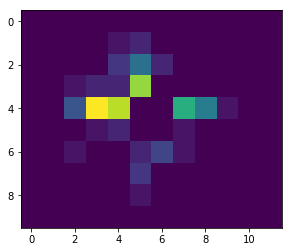

In [548]:
plt.imshow(den_maps_DA[17].reshape(10,12))
plt.savefig('soska.png')

In [520]:
den_maps_DA[19].reshape(10,12).sum()

0.3380447585394582

In [547]:
for i in range(len(den_maps_DA)): 
    den_maps_DA[i][4:6,5:7] = 0
    den_maps_HB[i][4:6,5:7] = 0
    den_maps_SC[i][4:6,5:7] = 0
    den_maps_DA[i] = den_maps_DA[i].reshape(-1,)/den_maps_DA[i].sum()
    den_maps_HB[i] = den_maps_HB[i].reshape(-1,)/den_maps_HB[i].sum()
    den_maps_SC[i] = den_maps_SC[i].reshape(-1,)/den_maps_SC[i].sum()

pd.DataFrame(np.array(den_maps_DA), columns = np.arange(n_rows * n_columns)).to_csv(path_write + 'den_map_DA')
pd.DataFrame(np.array(den_maps_HB), columns = np.arange(n_rows * n_columns)).to_csv(path_write + 'den_map_HB')
pd.DataFrame(np.array(den_maps_SC), columns = np.arange(n_rows * n_columns)).to_csv(path_write + 'den_map_SC')  

# pd.DataFrame(np.array(pupil_hists_DA), columns = np.arange(bins)).to_csv(path_write + 'pupil_hist_DA')
# pd.DataFrame(np.array(pupil_hists_HB), columns = np.arange(bins)).to_csv(path_write + 'pupil_hist_HB')
# pd.DataFrame(np.array(pupil_hists_SC), columns = np.arange(bins)).to_csv(path_write + 'pupil_hist_SC')

In [549]:


def kernel_func_one(mean_d,max_d):
    sigma = 0.2
    return np.exp(-1/2 * (mean_d + max_d)**2/(sigma**2)) 

def kernel_func_mixed(mean_p_d, max_p_d, mean_s_d,max_s_d):
    sigma = 0.2
    return np.exp(-1/2 * (mean_p_d + max_p_d)**2 +(mean_s_d + max_s_d)**2 /(sigma**2))


def kernel_calc_func(data_1, data_2):
    d_1 = np.linalg.norm(data_1[0] - data_2[0], ord = 2)
    d_2 = np.linalg.norm(data_1[1] - data_2[1], ord = 2)
    d_3 = np.linalg.norm(data_1[2] - data_2[2], ord = 2)
    mean_d = (d_1 + d_2 + d_3)/3



    max_d = np.max([d_1,d_2,d_3] )
    return kernel_func_one(mean_d,max_d)


def kernel_calc_func_mixed(data_1,data_2):
    d_s_1 = np.linalg.norm(data_1[0] - data_2[0],ord = 2)
    d_s_2 = np.linalg.norm(data_1[1] - data_2[1],ord = 2)
    d_s_3 = np.linalg.norm(data_1[2] - data_2[2],ord = 2)
    d_p_4 = np.linalg.norm(data_1[3] - data_2[3],ord = 2)
    d_p_5 = np.linalg.norm(data_1[4] - data_2[5],ord = 2)
    d_p_6 = np.linalg.norm(data_1[5] - data_2[5],ord = 2)
    mean_s_d = (d_p_1 + d_p_2 + d_p_3)/3
    max_s_d = np.max([d_p_1,d_p_2,d_p_3])
    mean_p_d = (d_s_1 + d_s_2 + d_s_3)/3
    max_p_d = np.max([d_s_1,d_s_2,d_s_3])
    return kernel_func_mixed(mean_p_d, max_p_d, mean_s_d,max_s_d)





In [550]:
def make_kernel_matrix(data_1, n_samples):
    K = np.zeros((n_samples,n_samples))
    for i in range(n_samples):
        for j in range(n_samples):
            K[i][j] = kernel_calc_func(data_1[i], data_1[j])
    return K

def make_kernel_matrix_mixed(data_1, n_samples):
    K = np.zeros((n_samples,n_samples))
    for i in range(n_samples):
        for j in range(n_samples):
            K[i][j] = kernel_calc_func_mixed(data_1[i], data_1[j])
    return K






In [551]:
def make_data_for_kernel(data_DA, data_HB, data_SC): 
    data = []
    for i in range(len(data_DA)):
        data.append([data_DA[i],data_HB[i],data_SC[i]])
    return data

def make_data_for_kernel_mixed(data_DA_s, data_HB_s, data_SC_s,data_DA_p, data_HB_p, data_SC_p): 
    data = []
    for i in range(len(data_DA)):
        data.append([data_DA_s[i],data_HB_s[i],data_SC_s[i],data_DA_p[i],data_HB_p[i],data_SC_p[i]])
    return data

In [552]:
K = make_kernel_matrix(make_data_for_kernel(den_maps_DA,den_maps_HB,den_maps_SC), 75)

In [553]:
def center_kernel_matrix(K):
    K_center = np.zeros(K.shape)
    size = K.shape[0]
    K_center = K - K.sum(axis = 0).reshape(-1,1)/size - K.sum(axis = 1 )/size + K.sum()/(size**2)
    return K_center

In [554]:
def centr_kernel_func(sample_1, sample_2, train_sample,K):
    K_12 = kernel_calc_func(sample_1, sample_2)
    K_1 = 0
    K_2 = 0
    for i in range(len(train_sample)):
        K_1 += kernel_calc_func(sample_1,train_sample[i])/len(train_sample)
        K_2 += kernel_calc_func(sample_2,train_sample[i])/len(train_sample)
    return K_12 - K_1 - K_2 + K.sum()/(len(train_sample))**2
        
    

In [555]:

def get_K(x, y, sigma=0.2):
    return np.exp(-1/(2*sigma**2)*(x+y)**2)
    
def get_projections(new_sample, train_samples, eigenvectors, K): 
    projections = []
    for eigen_idx in range(eigenvectors.shape[1]):
        projection = 0
        for element_idx, element in enumerate(train_samples):
            projection += eigenvectors[element_idx, eigen_idx] * centr_kernel_func(
                train_samples[element_idx], new_sample, train_samples, K)
        projections.append(projection)
    return np.asarray(projections)
            

In [556]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
scores = []
data_DA, data_HB, data_SC = den_maps_DA, den_maps_HB, den_maps_SC
data = make_data_for_kernel(data_DA, data_HB, data_SC)
data = np.array(data)
targets_p = np.array(targets_p)
k=2
for train_index, test_index in skf.split(data, targets_p):
    X_train, X_test = data[train_index], data[test_index]
    y_train, y_test = targets_p[train_index], targets_p[test_index]
    K = make_kernel_matrix(X_train, len(train_index))
    eigenvalues_1, eigenvectors_1 = np.linalg.eigh(center_kernel_matrix(K))
    eigenvalues = eigenvalues_1[len(train_index)- k :]
    eigenvectors = eigenvectors_1[:,len(train_index)- k: ]
    print(eigenvalues)
    for idx, eigenvalue in enumerate(eigenvalues):
        eigenvectors[:, idx] = eigenvectors[:, idx] / (eigenvalue * np.linalg.norm(eigenvectors[:, idx], ord=2))
    new_features_train = np.zeros((len(train_index), k))
    new_features_test = np.zeros((len(test_index), k))
    for i in range(len(train_index)):
        new_features_train[i] = get_projections(X_train[i], X_train, eigenvectors, K)
        print(i)
    for i in range(len(test_index)):
        new_features_test[i] = get_projections(X_test[i], X_train, eigenvectors, K)
    print('READY')
    nb_clf = GaussianNB()
    nb_clf.fit(new_features_train, y_train)
    score = accuracy_score(y_test, nb_clf.predict(new_features_test))
    scores.append(score)

[4.75854902 5.23935722]
0
1
2
3


KeyboardInterrupt: 

In [540]:
scores

[]

In [557]:
data_DA, data_HB, data_SC = den_maps_DA, den_maps_HB, den_maps_SC
data = make_data_for_kernel(data_DA, data_HB, data_SC)
data = np.array(data)
targets_p = np.array(targets_p)
k=2
K = make_kernel_matrix(make_data_for_kernel(den_maps_DA,den_maps_HB,den_maps_SC), 75)
eigenvalues_1, eigenvectors_1 = np.linalg.eigh(center_kernel_matrix(K))
eigenvalues = eigenvalues_1[len(data)- k :]
eigenvectors = eigenvectors_1[:,len(data)- k: ]

In [558]:
for idx, eigenvalue in enumerate(eigenvalues):
    eigenvectors[:, idx] = eigenvectors[:, idx] / (eigenvalue * np.linalg.norm(eigenvectors[:, idx], ord=2))
    new_features_train = np.zeros((len(data), k))
    new_features_test = np.zeros((len(test_index), k))
for i in range(len(data)):
    new_features_train[i] = get_projections(data[i],data, eigenvectors, K)
    print(i)


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74


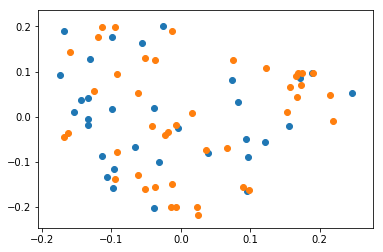

In [559]:
plt.scatter(new_features_train[:,0][0:32],new_features_train[:,1][0:32])
plt.scatter(new_features_train[:,0][32:],new_features_train[:,1][32:])

In [173]:
a = np.array([[1,2],
              [3,4]])

In [184]:
a - a.sum(axis = 1).reshape(-1,1)

array([[-2, -1],
       [-4, -3]])

In [183]:
a.sum(axis = 1)

array([3, 7])

In [192]:
eigenvalues_1

array([-1.47436063e-01, -8.21845858e-02, -5.56562030e-02, -3.80886633e-02,
       -2.56728528e-02, -2.02853360e-02, -1.34200601e-02, -1.16024484e-02,
       -5.18248851e-03, -4.41513583e-04,  1.63361214e-16,  1.08599752e-03,
        4.28119368e-03,  1.07732302e-02,  1.24594916e-02,  1.51887236e-02,
        1.67889826e-02,  2.06308933e-02,  2.21868415e-02,  2.64340599e-02,
        2.71715928e-02,  3.05251666e-02,  3.44248332e-02,  3.58673772e-02,
        3.74415659e-02,  3.90740880e-02,  4.28762274e-02,  4.48023221e-02,
        4.74120859e-02,  4.85740867e-02,  5.40444033e-02,  6.15287737e-02,
        6.74216848e-02,  6.90229891e-02,  7.25994265e-02,  7.92413251e-02,
        8.04426766e-02,  8.28736864e-02,  8.65723016e-02,  8.80199706e-02,
        9.60094395e-02,  9.65628614e-02,  1.03639572e-01,  1.08206353e-01,
        1.15876007e-01,  1.22652718e-01,  1.34065807e-01,  1.37790190e-01,
        1.40170868e-01,  1.43045617e-01,  1.51767684e-01,  1.65679763e-01,
        1.68927847e-01,  